In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display

import warnings 
warnings.filterwarnings('ignore')

In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [3]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [4]:
root = 'my_face/'

train_data = datasets.ImageFolder(os.path.join(root,'train'),transform=train_transform)
#test_data = datasets.ImageFolder(os.path.join(root,'test'),transform=test_transform)

In [5]:
torch.manual_seed(42)

train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
#test_loader = DataLoader(test_data,batch_size=10,shuffle=False,pin_memory=True)

class_names = train_data.classes

In [6]:
class_names

['glasses', 'no_glasses']

In [7]:
len(train_data)

1607

In [8]:
for images,labels in train_loader:
    break

In [9]:
# 10 images, 3 color channels, height 170, width 170
images.shape

torch.Size([10, 3, 170, 170])

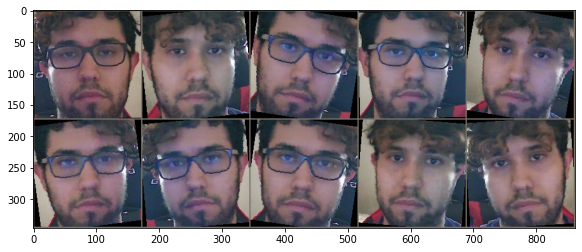

In [10]:
im = make_grid(images,nrow=5)

# De-normalize image
# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        # Initalizing inherited class
        super().__init__()
        # Convolutional network layers
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        
        # Fully connected network layers
        self.fc1 = nn.Linear(41*41*16,120)
        self.fc2 = nn.Linear(120,80)
        self.fc3 = nn.Linear(80,2)
        
    def forward(self,X):
        # Activation functions and pooling layers for convolutional layers
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
       
        # Flatten to go to fully connected network: -1 to keep same batch size
        X = torch.flatten(X,1)
        
        # Activation functions for fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        # Returning Activation function for output layer (final layer)
        return F.log_softmax(X,dim=1)

In [20]:
x = (170-2)/2
print(x)
x = (x-2)/2
print(x)

84.0
41.0


In [21]:
torch.manual_seed(101)

model = ConvolutionalNetwork()

model_loss = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=26896, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=2, bias=True)
)

In [22]:
total_params = 0
for p in model.parameters():
    total_params += p.numel()
    print(p.numel())
print('Total parameters:',total_params)

162
6
864
16
3227520
120
9600
80
160
2
Total parameters: 3238530


In [23]:
import time

In [24]:
start_time = time.time()

epochs = 10

# Limit on number of batches
#max_trn_batch = 1000 # batch 10 images -> 10000 images
#max_tst_batch = 300 # Batch 10 images -> 3000 images

# Trackers
train_losses = []
#test_losses = []
train_correct = []
#test_correct = []
print('========================================= Train Data metrics ===================================')
for i in range(epochs):
    print(f'================================== Epoch {i} ============================================')
    trn_corr = 0
    tst_corr = 0
    
    for b,(X_train,y_train) in enumerate(train_loader):
        X_train,y_train = X_train.to(device), y_train.to(device)
        
        # Optional limit number of batches
        #if b == max_trn_batch:
            #break
        b += 1
        
        y_pred = model(X_train)
        loss = model_loss(y_pred,y_train)
        
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad() # Zero out gradient before computing since pytorch keeps record of previous gradients
        loss.backward() # Go backwards in the network
        optimizer.step() # Update weights and biases in each layer
        
        if b%50 == 0:
            print(f'Batch: {b} out of 161 \t Loss {loss.item()} \t Accuracy {round(trn_corr.item()*100/(10*b),2)}%')
    train_losses.append(loss)
    train_correct.append(trn_corr)
    print('\n')
    
total_time = time.time() - start_time
print('Done!')
seconds = total_time % 60
print(f'Training time: {int(total_time/60)} minutes {round(seconds,2)} seconds')

========================================= Train Data metrics ===================================
================================== Epoch 0 ============================================
Batch: 50 out of 161 	 Loss 0.004693959839642048 	 Accuracy 85.6%
Batch: 100 out of 161 	 Loss 6.663733984169085e-06 	 Accuracy 92.8%
Batch: 150 out of 161 	 Loss 3.0636697374575306e-06 	 Accuracy 95.2%


================================== Epoch 1 ============================================
Batch: 50 out of 161 	 Loss 8.821476740195067e-07 	 Accuracy 100.0%
Batch: 100 out of 161 	 Loss 4.780220479005948e-06 	 Accuracy 100.0%
Batch: 150 out of 161 	 Loss 1.6212403579629608e-06 	 Accuracy 100.0%


================================== Epoch 2 ============================================
Batch: 50 out of 161 	 Loss 7.0928522291069385e-06 	 Accuracy 100.0%
Batch: 100 out of 161 	 Loss 7.629377023476991e-07 	 Accuracy 100.0%
Batch: 150 out of 161 	 Loss 2.3841850804728892e-07 	 Accuracy 100.0%


===============

In [31]:
train_correct

[tensor(1535, device='cuda:0'),
 tensor(1607, device='cuda:0'),
 tensor(1607, device='cuda:0'),
 tensor(1607, device='cuda:0'),
 tensor(1607, device='cuda:0'),
 tensor(1607, device='cuda:0'),
 tensor(1607, device='cuda:0'),
 tensor(1607, device='cuda:0'),
 tensor(1607, device='cuda:0'),
 tensor(1607, device='cuda:0')]

In [32]:
train_acc = [t/16.1 for t in train_correct]
train_acc

[tensor(95.3416, device='cuda:0'),
 tensor(99.8137, device='cuda:0'),
 tensor(99.8137, device='cuda:0'),
 tensor(99.8137, device='cuda:0'),
 tensor(99.8137, device='cuda:0'),
 tensor(99.8137, device='cuda:0'),
 tensor(99.8137, device='cuda:0'),
 tensor(99.8137, device='cuda:0'),
 tensor(99.8137, device='cuda:0'),
 tensor(99.8137, device='cuda:0')]

In [29]:
print(100*train_correct[-1].item()/1607,'%')

100.0 %


In [34]:
for images,labels in train_loader:
    break

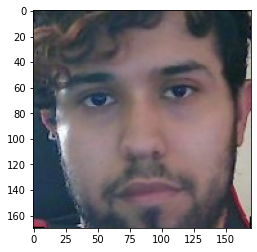

In [75]:
i = 9
im = inv_normalize(images[i])
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [76]:
model.eval()

with torch.no_grad():
    new_pred = model(images[i].view(1,3,170,170).cuda())

print(new_pred)

prob_tensor = new_pred
new_pred = new_pred.argmax()
class_names[new_pred.item()]

tensor([[-1.5787e+01, -1.1921e-07]], device='cuda:0')


'no_glasses'

In [65]:
import math

In [77]:
temp = math.exp(prob_tensor[0][0].item())
print('Probability you have Glasses:',round(100*temp,2),'%')

temp = math.exp(prob_tensor[0][1].item())
print('Probability you do not have Glasses:',round(100*temp,2),'%')

Probability you have Glasses: 0.0 %
Probability you do not have Glasses: 100.0 %


In [73]:
model.eval()
example = torch.rand(1,3,170,170).cuda()
traced_script_module = torch.jit.trace(model,example)

In [74]:
traced_script_module.save("glasses_or_not_torchScript_model.pt")